In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy


plt.ion()   # 대화형 모드

In [2]:

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop((224, 224)),
        transforms.RandomCrop(180),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'C:\\Users\\mgw15\\Desktop\\shoeprediction\\shoeTypeClassifierDataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x])for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

C:\Users\mgw15\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51312 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\mgw15\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 45912 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\mgw15\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 51312 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\mgw15\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 45912 missing from current font.
  font.set_text(s, 0, flags=flags)


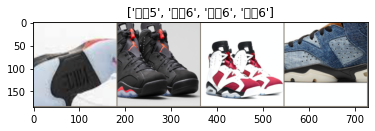

In [3]:
def imshow(inp, title=None):#일부 이미지 시각화
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


In [4]:
def train_model(model, criterion, optimizer, num_epochs=25): #, scheduler
    since = time.time()

#모델학습하기
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_loss, train_acc, valid_loss, valid_acc = [], [], [], []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0
            num_cnt = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
           # if phase == 'train':
               # scheduler.step()

            #epoch_loss = running_loss / dataset_sizes[phase]
            #epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_loss = float(running_loss / dataset_sizes[phase])
            epoch_acc  = float((running_corrects.double() / dataset_sizes[phase]).cpu()*100)

            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)


            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc:
                best_idx = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc

In [5]:
def visualize_model(model, num_images=8):#모델예측값 시각화하기
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [6]:
model_ft =models.resnet34(pretrained=True)#finetunning
num_ftrs = model_ft.fc.in_features
# 여기서 각 출력 샘플의 크기는 2로 설정합니다.
# 또는, nn.Linear(num_ftrs, len (class_names))로 일반화할 수 있습니다.
model_ft.fc = nn.Linear(num_ftrs, 3) #shoe

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.003, momentum=1.1)



In [7]:
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
# 파인 튜닝으로 학습할 파라미터를 params_to_update 변수의 1~3에 저장한다

params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []

# 학습시킬 층의 파라미터명을 지정
update_param_names_1 = ["conv1","conv2","conv3"]
update_param_names_3 = ["fc.weight", "fc.bias"]

# 파라미터를 각각 리스트에 저장
for name, param in model_ft.named_parameters():
  if update_param_names_1[0] in name:
        param.requires_grad = True #true
        params_to_update_1.append(param)
        print("params_to_update_1에 저장: ")
  elif update_param_names_1[1] in name:
        param.requires_grad = True #true
        params_to_update_1.append(param)
        print("params_to_update_1에 저장: ")
  elif update_param_names_1[2] in name:
        param.requires_grad = True #true
        params_to_update_1.append(param)
        print("params_to_update_1에 저장: ")       


  elif name in update_param_names_3:
      param.requires_grad = True
      params_to_update_3.append(param)
      print("params_to_update_3에 저장: ")

  else:
      param.requires_grad = False
      print("경사 계산없음. 학습하지 않음: ", name)

params_to_update_1에 저장: 
경사 계산없음. 학습하지 않음:  bn1.weight
경사 계산없음. 학습하지 않음:  bn1.bias
params_to_update_1에 저장: 
경사 계산없음. 학습하지 않음:  layer1.0.bn1.weight
경사 계산없음. 학습하지 않음:  layer1.0.bn1.bias
params_to_update_1에 저장: 
경사 계산없음. 학습하지 않음:  layer1.0.bn2.weight
경사 계산없음. 학습하지 않음:  layer1.0.bn2.bias
params_to_update_1에 저장: 
경사 계산없음. 학습하지 않음:  layer1.1.bn1.weight
경사 계산없음. 학습하지 않음:  layer1.1.bn1.bias
params_to_update_1에 저장: 
경사 계산없음. 학습하지 않음:  layer1.1.bn2.weight
경사 계산없음. 학습하지 않음:  layer1.1.bn2.bias
params_to_update_1에 저장: 
경사 계산없음. 학습하지 않음:  layer1.2.bn1.weight
경사 계산없음. 학습하지 않음:  layer1.2.bn1.bias
params_to_update_1에 저장: 
경사 계산없음. 학습하지 않음:  layer1.2.bn2.weight
경사 계산없음. 학습하지 않음:  layer1.2.bn2.bias
params_to_update_1에 저장: 
경사 계산없음. 학습하지 않음:  layer2.0.bn1.weight
경사 계산없음. 학습하지 않음:  layer2.0.bn1.bias
params_to_update_1에 저장: 
경사 계산없음. 학습하지 않음:  layer2.0.bn2.weight
경사 계산없음. 학습하지 않음:  layer2.0.bn2.bias
경사 계산없음. 학습하지 않음:  layer2.0.downsample.0.weight
경사 계산없음. 학습하지 않음:  layer2.0.downsample.1.weight
경사 계산없음. 학습하지

In [9]:
# 최적화 기법 설정
optimizer = optim.SGD([ #최적화 함수 SGD사용 
    {'params': params_to_update_1, 'lr': 1e-4}, #학습률 1e-4 0.0001
    {'params': params_to_update_3, 'lr': 1e-3} #학습률 1e-3 0.001
], momentum=0.9)
# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) #step size 마다 gamma비율로 lr감소

In [10]:
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc  = train_model(model_ft, criterion, optimizer, num_epochs=5)

Epoch 0/4
----------


C:\Users\mgw15\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 1.0603 Acc: 47.3333
val Loss: 1.0436 Acc: 45.6140

Epoch 1/4
----------
train Loss: 0.7466 Acc: 66.6667
val Loss: 1.2088 Acc: 43.8596

Epoch 2/4
----------
train Loss: 0.7397 Acc: 70.0000
val Loss: 1.1386 Acc: 40.3509

Epoch 3/4
----------
train Loss: 0.7768 Acc: 63.3333
val Loss: 1.2904 Acc: 45.6140

Epoch 4/4
----------
train Loss: 0.5727 Acc: 75.3333
val Loss: 1.0994 Acc: 52.6316

Training complete in 2m 14s
Best val Acc: 52.631579


In [12]:
torch.save(model, 'model.pth')

best model : 4 - 53 / 1.1


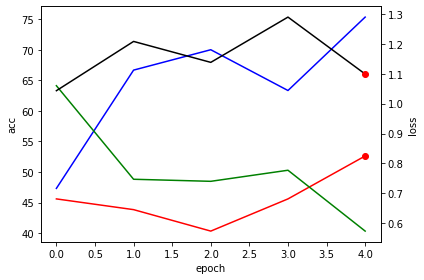

In [13]:
## 결과 그래프 그리기
print('best model : %d - %1.f / %.1f'%(best_idx, valid_acc[best_idx], valid_loss[best_idx]))
fig, ax1 = plt.subplots()

ax1.plot(train_acc, 'b-')
ax1.plot(valid_acc, 'r-')
plt.plot(best_idx, valid_acc[best_idx], 'ro')
ax1.set_xlabel('epoch')

ax1.set_ylabel('acc', color='k')
ax1.tick_params('y', colors='k')

ax2 = ax1.twinx()
ax2.plot(train_loss, 'g-')
ax2.plot(valid_loss, 'k-')
plt.plot(best_idx, valid_loss[best_idx], 'ro')
ax2.set_ylabel('loss', color='k')
ax2.tick_params('y', colors='k')

fig.tight_layout()
plt.show()

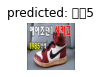

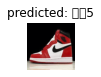

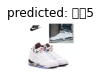

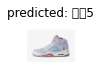

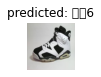

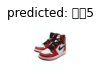

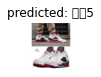

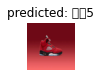

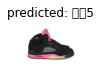

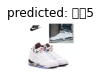

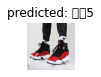

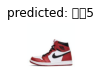

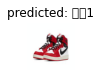

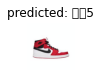

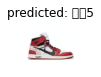

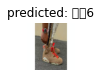

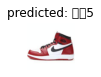

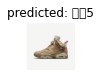

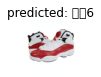

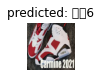

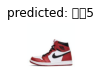

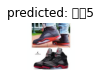

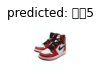

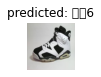

In [14]:
for x in range(3):
  visualize_model(model_ft)

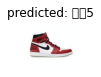

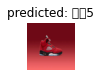

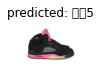

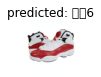

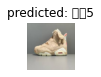

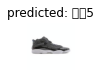

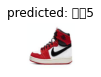

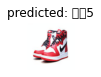

In [15]:
visualize_model(model_ft)

plt.ioff()
plt.show()

In [16]:
import io
import json

from torchvision import models
import torchvision.transforms as transforms
from PIL import Image

from flask import Flask, jsonify, request
from flask import render_template

TEMPLATE_FOLDER = 'c:\\Users\\mgw15\\Desktop\\shoeprediction\\templates'

app = Flask(__name__, template_folder=TEMPLATE_FOLDER)

model = torch.load('model.pth')
model.eval()
debug = True
def transform_image(image_bytes):
    data_transforms = transforms.Compose([transforms.Resize(255),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                          transforms.Normalize(
                                              [0.485, 0.456, 0.406],
                                              [0.229, 0.224, 0.225])])
    image = Image.open(io.BytesIO(image_bytes))
    return data_transforms(image).unsqueeze(0)

def get_prediction(image_bytes):
    tensor = transform_image(image_bytes=image_bytes)
    outputs = model.forward(tensor)
    _, y_hat = outputs.max(1)
    predicted_idx = str(y_hat.item())
    return model_ft[predicted_idx]
# html 연결
@app.route('/')
def main():
    return render_template('shoeweb.html')
# 사진 분류
@app.route('/predict', methods=['POST'])
def predict():
    if request.method == 'POST':
        file = request.files['file']
        img_bytes = file.read()
        class_id, class_name = get_prediction(image_bytes=img_bytes)
        return jsonify({'class_id': class_id, 'class_name': class_name})
if __name__ == '__main__':
    app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [16/Dec/2021 02:06:40] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [16/Dec/2021 02:06:40] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [16/Dec/2021 02:06:53] "POST /predict HTTP/1.1" 400 -
127.0.0.1 - - [16/Dec/2021 02:06:56] "POST /predict HTTP/1.1" 400 -
127.0.0.1 - - [16/Dec/2021 02:07:07] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [16/Dec/2021 02:07:08] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [16/Dec/2021 02:09:13] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [16/Dec/2021 02:09:23] "POST /predict HTTP/1.1" 400 -
127.0.0.1 - - [16/Dec/2021 02:09:25] "POST /predict HTTP/1.1" 400 -
